# Imports


In [1]:
# Provides ways to work with large multidimensional arrays
import numpy as np

# Allows for further data manipulation and analysis
import pandas as pd
import matplotlib.pyplot as plt  # Plotting
import matplotlib.dates as mdates  # Styling dates

import datetime as dt

import time

import yfinance as yf

# Used for file handling like deleting files
# and get data from a directory
import os
from os import listdir
from os.path import isfile, join

import cufflinks as cf
import plotly.express as px
import plotly.graph_objects as go

# Make plotly work in your Jupyter Notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
# Use plotly locally
cf.go_offline()

from plotly.subplots import make_subplots

import warnings

warnings.simplefilter("ignore")


# Constants


In [4]:
PATH = "C:\\Users\\Eduardo Nuñez\\OneDrive\\Python\\Derek Banas\\Investing\\Currencies\\Currency Data\\"

# Start end date defaults
S_DATE = "2017-02-01"
E_DATE = "2022-12-06"
S_DATE_DT = pd.to_datetime(S_DATE)
E_DATE_DT = pd.to_datetime(E_DATE)

risk_free_rate = 0.0125  # Approximate 10 year bond rate


# Get Stock File Names in a List


In [5]:
files = [x for x in listdir(PATH) if isfile(join(PATH, x))]
tickers = [os.path.splitext(x)[0] for x in files]

tickers.sort()
len(tickers)
# print(tickers)


['AUDUSD=X', 'CHFJPY=X', 'EURUSD=X', 'GBPUSD=X']


# Function that Returns a Dataframe from a CSV


In [6]:
def get_stock_df_from_csv(ticker):
    try:
        df = pd.read_csv(PATH + ticker + ".csv", index_col=0)
    except FileNotFoundError as ex:
        print(ex)
    else:
        return df


# Merge Multiple Stocks in One Dataframe by Column Name


In [7]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()

    for x in tickers:
        df = get_stock_df_from_csv(x)

        # NEW Check if your dataframe has duplicate indexes
        # if not df.index.is_unique:
        #   # Delete duplicates
        #   df = df.loc[~df.index.duplicated()]

        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]

    return mult_df


# Markowitz Portfolio Optimization

Harry Markowitz proved that you could make what is called an efficient portfolio. That is a portfolio that optimizes return while also minimizing risk. We don't benefit from analyzing individual securities at the same rate as if we instead considered a portfolio of stocks.

We do this by creating portfolio with stocks that are not correlated. We want to calculate expected returns by analyzing the returns of each stock multiplied by its weight.

$ w_{1}r_{1} + w_{2}r_{2} = r_{p} $ The return of a portfolio is a linear combination of the returns of each stock.

The standard deviation of the portfolio is found this way. Sum multiple calculations starting by finding the product of the first securities weight squared times its standard deviation squared. The middle is 2 times the correlation coefficient between the stocks. And, finally add those to the weight squared times the standard deviation squared for the second security.

$ (w_{1}\sigma_{1} + w_{2}\sigma_{2})^{2} = w_{1}^{2}\sigma_{1}^{2} + 2w_{1}\sigma_{1}w_{2}\sigma_{2}\rho_{1} + w_{2}^{2}\sigma\_{2}^{2}$

# Plotting an Efficient Frontier

# Stock Portfolio

Choose a group of Stocks based on the previous analyses (considering, 5 year, 1 year, 6 months periods at least), and maybe another group of Stocks for a second iteration.


In [8]:
port_list = ["AUDUSD=X", "CHFJPY=X", "EURUSD=X", "GBPUSD=X"]
num_stocks = len(port_list)
num_stocks


4

# Merge all data by Closing Price


In [9]:
mult_df = merge_df_by_column_name("Close", S_DATE, E_DATE, *port_list)
mult_df


,AUDUSD=X,CHFJPY=X,EURUSD=X,GBPUSD=X
Date,,,,
2017-03-14,0.756659,114.028999,1.065144,1.220599
2017-03-15,0.756550,113.570000,1.061244,1.215746
2017-03-16,0.770594,113.389999,1.073791,1.228426
2017-03-17,0.766989,113.779999,1.077470,1.235117
2017-03-20,0.770475,112.919998,1.074299,1.238451
...,...,...,...,...
2022-03-08,0.732850,124.620239,1.086531,1.311230
2022-03-09,0.726792,124.475998,1.089823,1.309929
2022-03-10,0.731690,125.080399,1.107383,1.318565


# Change values to USD

In [11]:
JPY_to_USD = 0.0085
mult_df["CHFJPY=X"] = mult_df["CHFJPY=X"] * JPY_to_USD
mult_df


,AUDUSD=X,CHFJPY=X,EURUSD=X,GBPUSD=X
Date,,,,
2017-03-14,0.756659,0.969246,1.065144,1.220599
2017-03-15,0.756550,0.965345,1.061244,1.215746
2017-03-16,0.770594,0.963815,1.073791,1.228426
2017-03-17,0.766989,0.967130,1.077470,1.235117
2017-03-20,0.770475,0.959820,1.074299,1.238451
...,...,...,...,...
2022-03-08,0.732850,1.059272,1.086531,1.311230
2022-03-09,0.726792,1.058046,1.089823,1.309929
2022-03-10,0.731690,1.063183,1.107383,1.318565


# Plot Price of Investments over Total Dataset


In [12]:
fig = px.line(mult_df, x=mult_df.index, y=mult_df.columns)
fig.update_xaxes(title="Date", rangeslider_visible=True)
fig.update_yaxes(title="Price")
fig.update_layout(height=800, width=1200, showlegend=True)
fig.show()


# Cumulative Return for all stocks


In [13]:
mult_cum_df = merge_df_by_column_name("cum_return", S_DATE, E_DATE, *port_list)
mult_cum_df


,AUDUSD=X,CHFJPY=X,EURUSD=X,GBPUSD=X
Date,,,,
2017-03-14,NaN,NaN,NaN,NaN
2017-03-15,0.999856,0.995975,0.996339,0.996025
2017-03-16,1.018417,0.994396,1.008118,1.006412
2017-03-17,1.013652,0.997816,1.011572,1.011894
2017-03-20,1.018260,0.990274,1.008594,1.014626
...,...,...,...,...
2022-03-08,0.968534,1.092882,1.020079,1.074251
2022-03-09,0.960528,1.091617,1.023170,1.073186
2022-03-10,0.967001,1.096917,1.039655,1.080261


In [14]:
fig = px.line(mult_cum_df, x=mult_cum_df.index, y=mult_cum_df.columns)
fig.update_xaxes(title="Date", rangeslider_visible=True)
fig.update_yaxes(title="Price")
fig.update_layout(height=800, width=1200, showlegend=True)
fig.show()


# Mean Returns

The logarithmic return is the relation:

$ R = \large ln(\frac{V_{f}}{V_{i}}) $

Where:

$ R = $ Rate of return

$ V_{f} = $ Value at the end of the period

$ V_{i} = $ Value at the beginning of the period

The same can be written in exponential for:

$ V_{f} = V_{i}e^{Rt} $

Where:

$ t = $ number of periods between i and f

In [15]:
# print(mult_df)

# pre_log_returns = mult_df/mult_df.shift(1)
# print(pre_log_returns)

returns = np.log(mult_df / mult_df.shift(1)) # This is using the logarithmic return.
print(returns)
mean_ret = returns.mean() * 252 # there are 252 trading days in a year, and since we are working with daily data we should multiply the mean() by 252 to get an annual value.
mean_ret


            AUDUSD=X  CHFJPY=X  EURUSD=X  GBPUSD=X
Date                                              
2017-03-14       NaN       NaN       NaN       NaN
2017-03-15 -0.000144 -0.004033 -0.003668 -0.003983
2017-03-16  0.018393 -0.001586  0.011753  0.010375
2017-03-17 -0.004690  0.003434  0.003420  0.005432
2017-03-20  0.004535 -0.007587 -0.002948  0.002696
...              ...       ...       ...       ...
2022-03-08 -0.009008 -0.002226 -0.000848 -0.007612
2022-03-09 -0.008301 -0.001158  0.003025 -0.000992
2022-03-10  0.006717  0.004844  0.015984  0.006571
2022-03-11  0.006688 -0.000691 -0.005422 -0.006270
2022-03-14 -0.014589  0.006753 -0.009384 -0.006556

[1302 rows x 4 columns]


AUDUSD=X   -0.008030
CHFJPY=X    0.019092
EURUSD=X    0.004665
GBPUSD=X    0.012470
dtype: float64

# Correlation

We look for not correlated stocks to form our portfolio. Ideally the correlations should be less than 0.5.


In [16]:
returns.corr()


,AUDUSD=X,CHFJPY=X,EURUSD=X,GBPUSD=X
AUDUSD=X,1.000000,0.214124,0.542839,0.554544
CHFJPY=X,0.214124,1.000000,0.358848,0.212458
EURUSD=X,0.542839,0.358848,1.000000,0.575539
GBPUSD=X,0.554544,0.212458,0.575539,1.000000


# Generate Random Weights Summing 1


In [17]:
weights = np.random.random(num_stocks)
weights /= np.sum(weights)
print("Weights :", weights)
print("Total Weight :", np.sum(weights))


Weights : [0.1889235  0.33349075 0.00618663 0.47139912]
Total Weight : 1.0


# Calculating Return of Portfolio using a Random Weighting


In [18]:
np.sum(weights * returns.mean()) * 252


0.010756974769336564

# Covariance

In [19]:
returns.cov()

,AUDUSD=X,CHFJPY=X,EURUSD=X,GBPUSD=X
AUDUSD=X,0.000033,0.000005,0.000013,0.000017
CHFJPY=X,0.000005,0.000015,0.000006,0.000004
EURUSD=X,0.000013,0.000006,0.000018,0.000013
GBPUSD=X,0.000017,0.000004,0.000013,0.000029


# Calculate Volatility

For discrete random variables, the volatility (standard deviation) of independent (cov = 0) variables is:

$ \sigma = \sqrt{\sum_{i=1}^{N}p_{i}(x_{i}-\mu)^2} $

But, in the case of correlated random variables the variance will be:

$ \small \mathrm{VAR}(\sum_{i=1}^{n} p_{i}X_{i}) = \sum_{i,j}p_{i}p_{j}\mathrm{COV}(X_{i},X_{j}) $

Where:

$ p_{i}, p_{j} = $ Weights for each random variable

Expressed in a vector notation, using the dot product we have:

$ \vec{q} = \vec{COV}(X_{i},X_{j}) \cdot \vec{p} \Rightarrow$      COV is matrix of covariances between all different stocks in the portfolio, thus this product gives a vector as output

$ \sqrt{\vec{p} \cdot \vec{q}} = $ Volatility of the portfolio


In [20]:
np.dot(returns.cov() * 252, weights)


array([0.00405253, 0.00203437, 0.00267296, 0.00460512])

In [21]:
# Volatility
np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights))) # This is a weighted standard deviation of the returns of the stocks


0.060261491525668835

# Analyzing Returns & Risks of 10000 Combinations

In [22]:
p_ret = []  # Returns for each portfolio
p_vol = []  # Volatility for each portfolio
p_SR = []  # Sharpe Ratio for each portfolio
p_wt = []  # Weights for each portfolio

for x in range(10000):
    # Calculate random weights
    p_weights = np.random.random(num_stocks)
    p_weights /= np.sum(p_weights)

    # Calculate the return for this particular combination and append
    ret_1 = np.sum(p_weights * returns.mean()) * 252
    p_ret.append(ret_1)

    # Calculate the volatility for this particular combination and append
    vol_1 = np.sqrt(np.dot(p_weights.T, np.dot(returns.cov() * 252, p_weights)))
    p_vol.append(vol_1)

    # Calculate the Sharpe Ratio and append
    SR_1 = (ret_1 - risk_free_rate) / vol_1
    p_SR.append(SR_1)

    p_wt.append(p_weights)

p_ret = np.array(p_ret)
p_vol = np.array(p_vol)
p_SR = np.array(p_SR)
p_wt = np.array(p_wt)

p_ret, p_vol, p_SR, p_wt


(array([0.00642593, 0.00175378, 0.00995066, ..., 0.00963808, 0.00086622,
        0.01391203]),
 array([0.05906493, 0.06507041, 0.0593628 , ..., 0.05827487, 0.06820681,
        0.05327233]),
 array([-0.10283721, -0.16514757, -0.04294515, ..., -0.0491107 ,
        -0.17056624,  0.02650588]),
 array([[0.24877   , 0.19758956, 0.28860656, 0.26503388],
        [0.38903961, 0.05979758, 0.40189198, 0.14927083],
        [0.01494609, 0.1715405 , 0.42903826, 0.38447515],
        ...,
        [0.132412  , 0.25034027, 0.22742195, 0.38982578],
        [0.62090705, 0.24471941, 0.06351309, 0.07086045],
        [0.08555232, 0.70625907, 0.18974771, 0.0184409 ]]))

# Plotting the Efficient Frontier

<AxesSubplot:xlabel='Volatility', ylabel='Returns'>

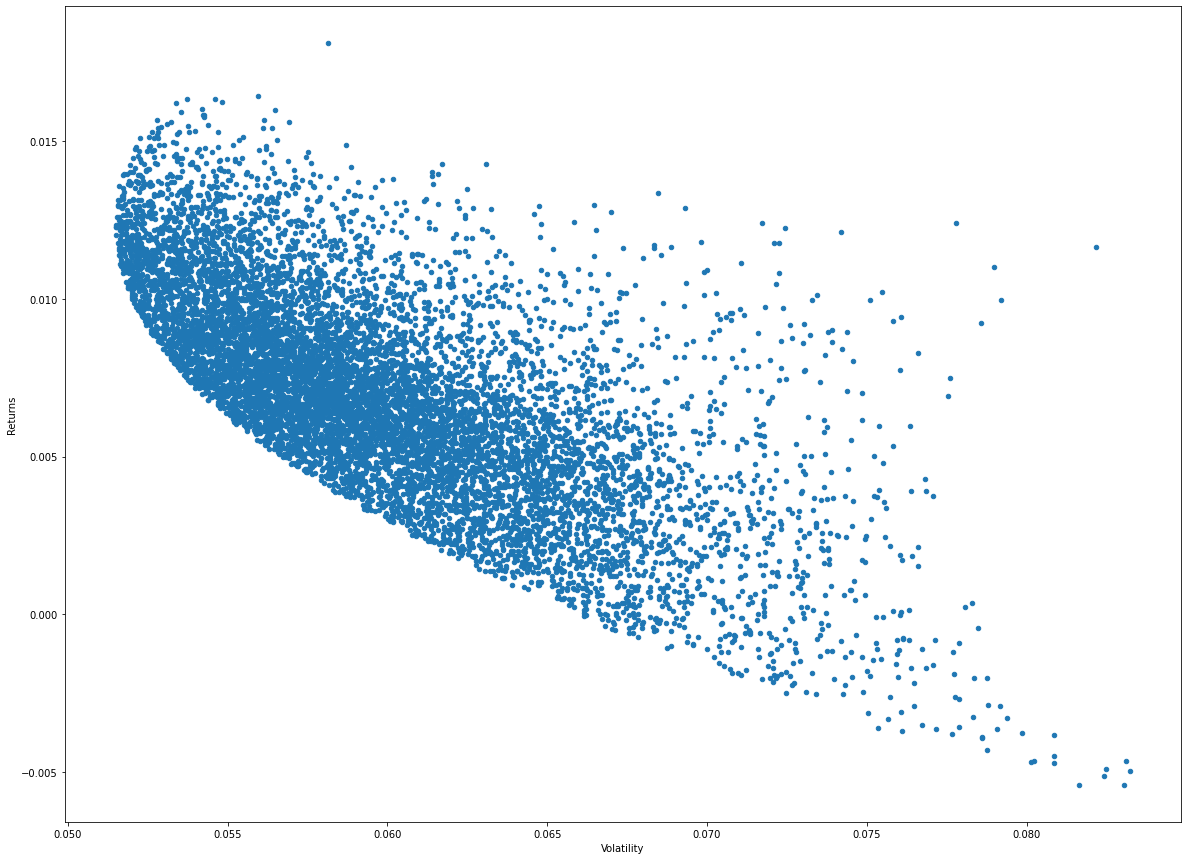

In [23]:
ports = pd.DataFrame({"Returns": p_ret, "Volatility": p_vol})
ports.plot(x="Volatility", y="Returns", kind="scatter", figsize=(20, 15))


# Sharpe Ratio

People want to maximize returns while avoiding as much risk as possible. William Sharpe created the Sharpe Ratio to find a portfolio that provides the best return for the lowest amount of risk.

$ Sharpe Ratio = \Large\frac{r_{i}-r_{f}}{\sigma_{i}}$

$ \Large r_{f} = $ Risk Free Rate

$ \Large r_{i} = $ Rate of Return of the Stock

$ \Large \sigma_{i} = $ Standard deviation of the Stock

As return increases so does the Sharpe Ratio, but as Standard Deviation increase the Sharpe Ratio Decreases

In [24]:
SR_idx = np.argmax(p_SR)

i = 0
while i < num_stocks:
    print("Stock : %s : %2.2f" % (port_list[i], (p_wt[SR_idx][i] * 100)))
    i += 1

print("\nVolatility :", p_vol[SR_idx])
print("Return :", p_ret[SR_idx])


Stock : AUDUSD=X : 0.66
Stock : CHFJPY=X : 90.54
Stock : EURUSD=X : 2.94
Stock : GBPUSD=X : 5.87

Volatility : 0.05813895671799457
Return : 0.018101093574587553


# Amount of shares to buy

In [25]:
def get_port_shares(one_price, force_one, wts, prices):
    # Gets number of stocks to analyze
    num_stocks = len(wts)

    # Holds the number of shares for each stock
    shares = []

    # Holds cost of shares for each stock
    cost_shares = []

    i = 0
    while i < num_stocks:
        # Get max amount to spent on stock
        max_price = one_price * wts[i]

        # Gets number of shares to buy and adds them to list
        num_shares = int(max_price / prices[i])

        # If the user wants to force buying one share, then do it
        if force_one and num_shares == 0:
            num_shares = 1

        shares.append(num_shares)

        # Gets cost of those shares and appends to the list
        cost = num_shares * prices[i]
        cost_shares.append(cost)
        i += 1

    return shares, cost_shares


# Get Portfolio Weighting

In [26]:
def get_port_weighting(share_cost):
    # Holds weights for stocks
    stock_wts = []

    # All values summed
    tot_val = sum(share_cost)
    print("Total Investment :", tot_val)

    for x in share_cost:
        stock_wts.append(x / tot_val)

    return stock_wts


# Returns the value of portfolio by Date

In [27]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name("Close", date, date, *port_list)

    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()

    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices,[])
    return port_prices


# Approximate Portfolio Weighting based on Request

In [30]:
port_list = ["AUDUSD=X", "CHFJPY=X", "EURUSD=X", "GBPUSD=X"]

port_wts = [2, 90, 3, 5]

# print(sum(port_wts))

# Get all stock prices on the starting date (when you make the investment)
port_df_start = merge_df_by_column_name("Close", "2022-01-07", "2022-01-07", *port_list)
# print(port_df_start)

# Convert from dataframe to Python list
port_prices = port_df_start.values.tolist()
# print(port_prices)

# Trick that converts a list of lists into a single list
port_prices = sum(port_prices, [])
# print(port_prices)

one_price = 0.725
tot_shares, share_cost = get_port_shares(one_price, True, port_wts, port_prices)
print("Shares :", tot_shares)
print("Share Cost :", share_cost)

# Get list of weights for stocks
stock_wts = get_port_weighting(share_cost)
print("Stock Weights :", stock_wts)

# Get value at end of year
port_df_end = get_port_val_by_date("2022-03-10", tot_shares, port_list)
print(port_df_end)


Shares : [2, 1, 1, 2]
Share Cost : [1.4325200319290161, 125.73300170898438, 1.1296881437301636, 2.70672607421875]
Total Investment : 131.0019359588623
Stock Weights : [0.010935105816900761, 0.9597797222513376, 0.008623446176283321, 0.020661725755478345]
[0.731689989566803, 125.08039855957033, 1.107382893562317, 1.3185653686523438]
